In [1]:
!nvidia-smi

Wed Jun 10 09:25:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# !unzip /content/drive/My\ Drive/summer2winter_yosemite.zip

In [0]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm, tqdm_notebook
import glob
import random
import itertools
import torchvision.utils as vutils

%matplotlib inline

In [0]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [0]:
batch_size = 6
image_size = 148

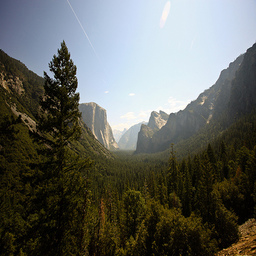

In [7]:
image = Image.open("/content/summer2winter_yosemite/testA/2010-09-07 12:23:20.jpg")
image

In [0]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, unaligned=False, mode="train"):
        self.transform = transform
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, f"{mode}A") + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, f"{mode}B") + "/*.*"))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))

        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [0]:
dataset = ImageDataset(root=os.path.join("/content/", "summer2winter_yosemite"),
                       transform=transforms.Compose([
                           transforms.Resize(image_size, Image.BICUBIC),
                          #  transforms.RandomCrop(image_size),
                           transforms.RandomHorizontalFlip(),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]),
                           mode= 'test'
                       )
inv_normalize = transforms.Normalize(
    mean=[-1., -1., -1.],
    std=[2., 2., 2.]
)


dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [0]:
unloader = transforms.ToPILImage()

def imshow(tensor, title):
    plt.figure()
    
    image = inv_normalize(tensor.cpu().clone())  
    image = unloader(image)
    plt.imshow(image)
    plt.title(title)
    plt.pause(0.001) 

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # nn.Conv2d(256, 256, 4, padding=1),
            # nn.InstanceNorm2d(256),
            # nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, padding=1)
            # nn.Conv2d(256, 1, 4, padding=1),

            # trying to do 512 in last layer CNN, its overvit on 10 epochs
        )

    def forward(self, x):
        x = self.main(x)
        x = F.avg_pool2d(x, x.size()[2:])
        x = torch.flatten(x, 1)
        return x

In [0]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Initial convolution block
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            # Downsampling
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),

            # Residual blocks
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            # ResidualBlock(256),
            # may be last 3 dont need i dont remember

            # Upsampling
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            # Output layer
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.res = nn.Sequential(nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels),
                                 nn.ReLU(inplace=True),
                                 nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels))

    def forward(self, x):
        return x + self.res(x)

In [0]:
cycle_loss = torch.nn.L1Loss().to(device)
identity_loss = torch.nn.L1Loss().to(device)
adversarial_loss = torch.nn.MSELoss().to(device)

In [0]:
netG_A2B = Generator().to(device)
netG_B2A = Generator().to(device)
netD_A = Discriminator().to(device)
netD_B = Discriminator().to(device)

In [12]:
netG_A2B.load_state_dict(torch.load(f"/content/drive/My Drive/weights_gan19/summer2winter_yosemite/netG_A2B.pth"))
netG_B2A.load_state_dict(torch.load(f"/content/drive/My Drive/weights_gan19/summer2winter_yosemite/netG_B2A.pth"))
netD_A.load_state_dict(torch.load(f"/content/drive/My Drive/weights_gan19/summer2winter_yosemite/netD_A.pth"))
netD_B.load_state_dict(torch.load(f"/content/drive/My Drive/weights_gan19/summer2winter_yosemite/netD_B.pth"))

RuntimeError: ignored

In [0]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert (max_size > 0), "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)


[0/51] Loss_D: 0.3655 Loss_G: 3.8875 Loss_G_identity: 0.8845 loss_G_GAN: 1.0606 loss_G_cycle: 1.9423:   0%|          | 0/52 [00:00<?, ?it/s]

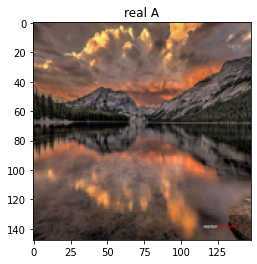

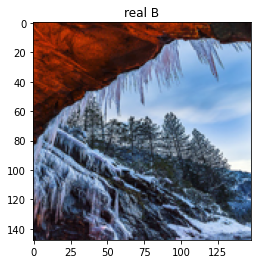

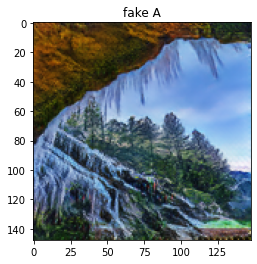

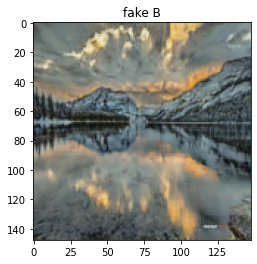

[5/51] Loss_D: 0.3457 Loss_G: 5.1257 Loss_G_identity: 1.3563 loss_G_GAN: 1.1479 loss_G_cycle: 2.6214:  10%|▉         | 5/52 [00:03<00:32,  1.45it/s]

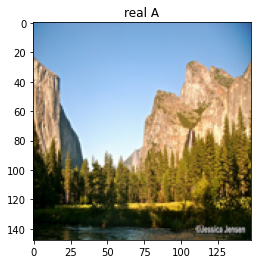

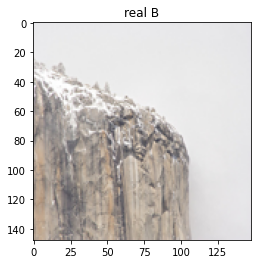

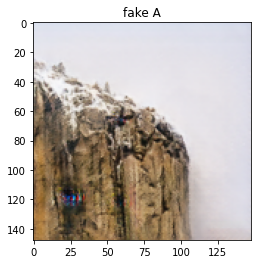

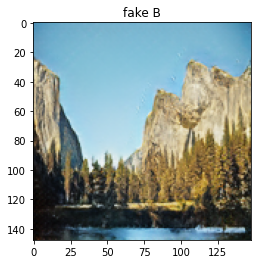

[10/51] Loss_D: 0.4002 Loss_G: 4.2371 Loss_G_identity: 0.9324 loss_G_GAN: 1.1837 loss_G_cycle: 2.1210:  19%|█▉        | 10/52 [00:06<00:24,  1.75it/s]

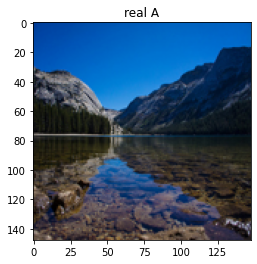

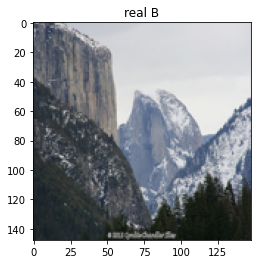

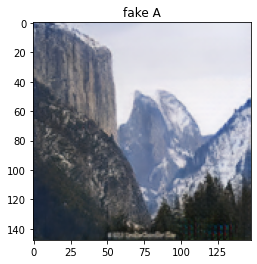

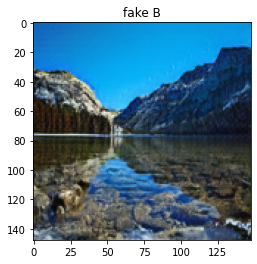

[15/51] Loss_D: 0.4221 Loss_G: 3.7479 Loss_G_identity: 0.8932 loss_G_GAN: 0.9753 loss_G_cycle: 1.8794:  29%|██▉       | 15/52 [00:10<00:20,  1.81it/s]

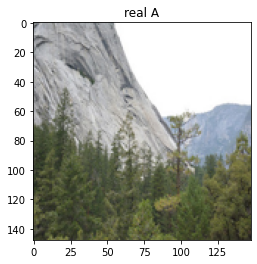

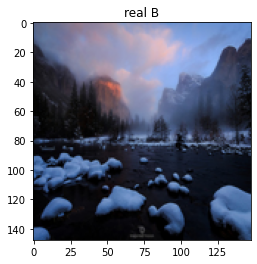

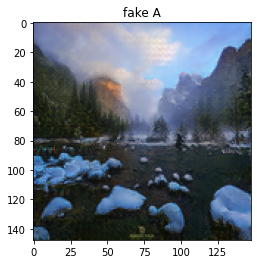

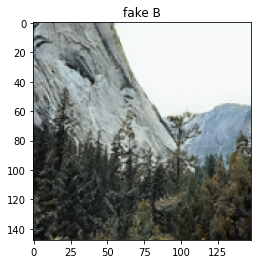

[20/51] Loss_D: 0.3241 Loss_G: 3.7186 Loss_G_identity: 0.7926 loss_G_GAN: 1.1579 loss_G_cycle: 1.7680:  38%|███▊      | 20/52 [00:13<00:17,  1.81it/s]

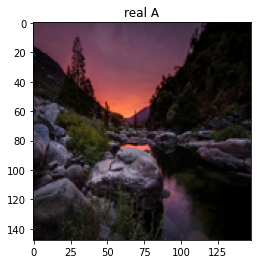

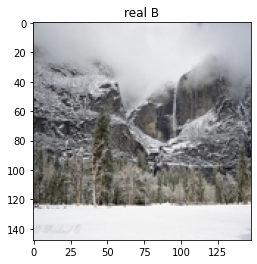

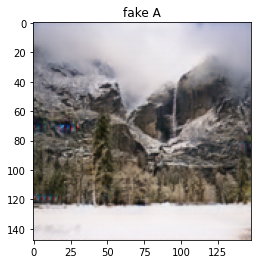

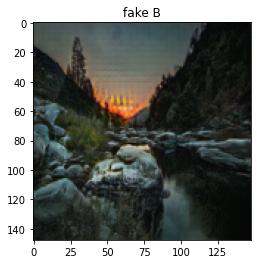

[25/51] Loss_D: 0.3283 Loss_G: 4.5248 Loss_G_identity: 1.0802 loss_G_GAN: 1.0527 loss_G_cycle: 2.3919:  48%|████▊     | 25/52 [00:16<00:14,  1.83it/s]

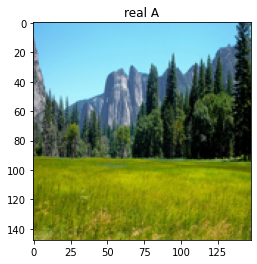

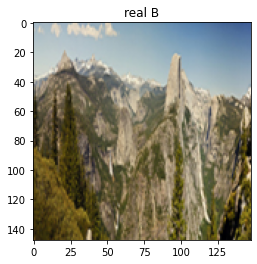

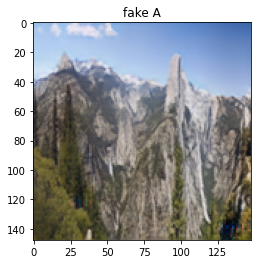

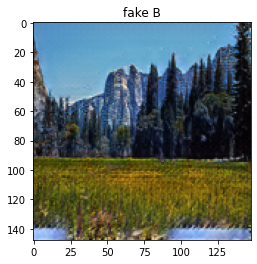

[30/51] Loss_D: 0.3190 Loss_G: 5.2914 Loss_G_identity: 1.4013 loss_G_GAN: 1.1572 loss_G_cycle: 2.7330:  58%|█████▊    | 30/52 [00:19<00:12,  1.83it/s]

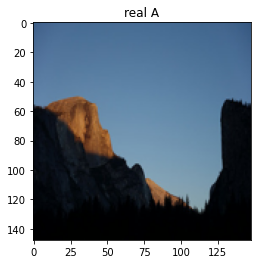

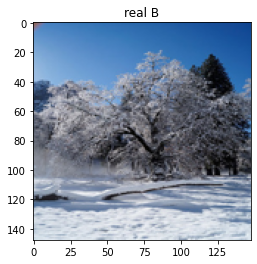

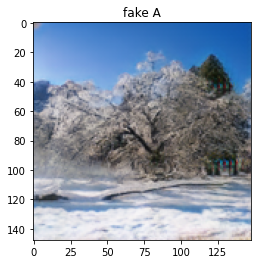

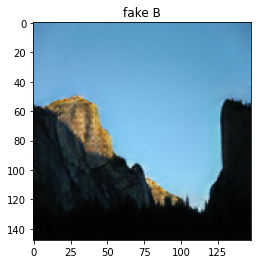

[35/51] Loss_D: 0.3644 Loss_G: 4.4676 Loss_G_identity: 1.1064 loss_G_GAN: 1.0617 loss_G_cycle: 2.2996:  67%|██████▋   | 35/52 [00:22<00:09,  1.83it/s]

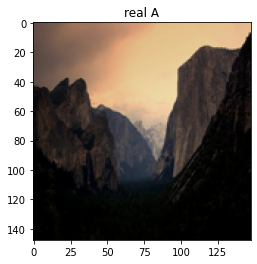

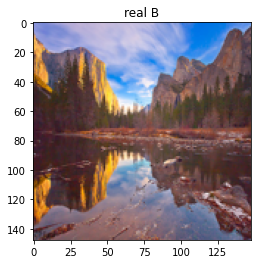

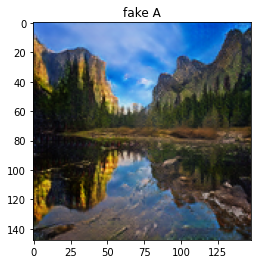

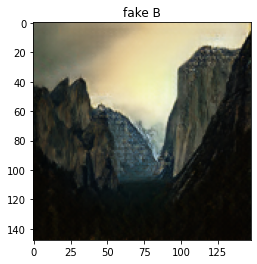

[40/51] Loss_D: 0.3898 Loss_G: 4.0389 Loss_G_identity: 0.9151 loss_G_GAN: 1.0527 loss_G_cycle: 2.0711:  77%|███████▋  | 40/52 [00:26<00:06,  1.81it/s]

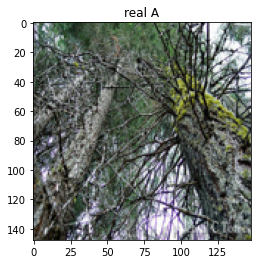

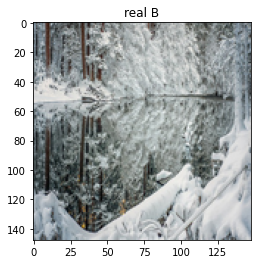

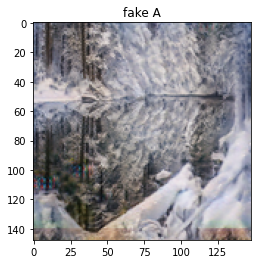

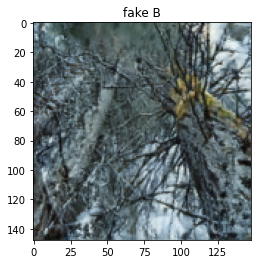

[45/51] Loss_D: 0.3272 Loss_G: 4.2078 Loss_G_identity: 0.8799 loss_G_GAN: 1.2575 loss_G_cycle: 2.0704:  87%|████████▋ | 45/52 [00:29<00:03,  1.81it/s]

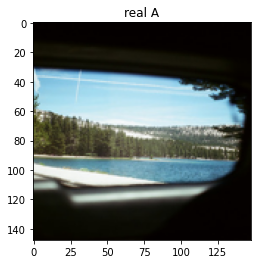

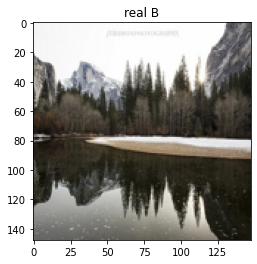

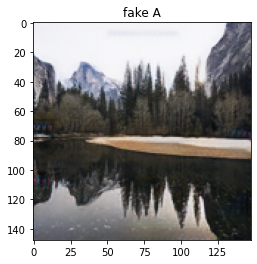

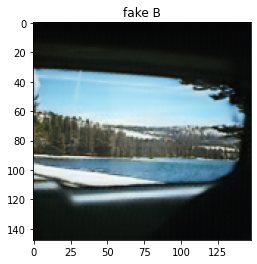

[50/51] Loss_D: 0.2760 Loss_G: 4.6555 Loss_G_identity: 1.1018 loss_G_GAN: 1.3334 loss_G_cycle: 2.2202:  96%|█████████▌| 50/52 [00:32<00:01,  1.81it/s]

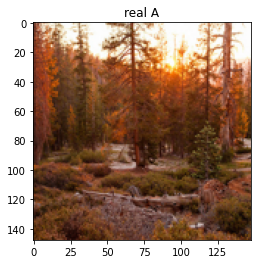

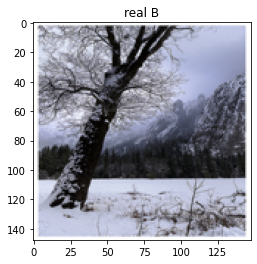

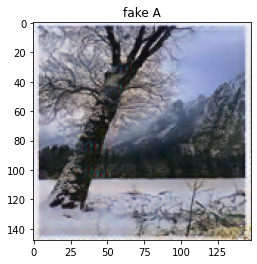

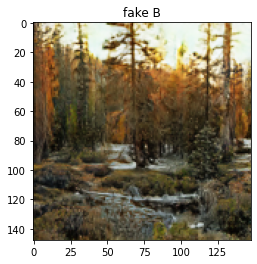

[51/51] Loss_D: 0.4731 Loss_G: 3.7899 Loss_G_identity: 0.8026 loss_G_GAN: 1.1603 loss_G_cycle: 1.8270: 100%|██████████| 52/52 [00:33<00:00,  1.55it/s]


In [17]:
netG_A2B.eval()
netG_B2A.eval()
netD_A.eval()
netD_B.eval()

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()
g_losses = []
d_losses = []

identity_losses = []
gan_losses = []
cycle_losses = []
print_freq=5

progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
for i, data in progress_bar:
    # get batch size data
    real_image_A = data["A"].to(device)
    real_image_B = data["B"].to(device)
    batch_size = real_image_A.size(0)

    # real data label is 1, fake data label is 0.
    real_label = torch.full((batch_size, 1), 1, device=device, dtype=torch.float32)
    fake_label = torch.full((batch_size, 1), 0, device=device, dtype=torch.float32)

    ##############################################
    # (1) Update G network: Generators A2B and B2A
    ##############################################


    # Identity loss
    # G_B2A(A) should equal A if real A is fed
    identity_image_A = netG_B2A(real_image_A)
    loss_identity_A = identity_loss(identity_image_A, real_image_A) * 5.0
    # G_A2B(B) should equal B if real B is fed
    identity_image_B = netG_A2B(real_image_B)
    loss_identity_B = identity_loss(identity_image_B, real_image_B) * 5.0

    # GAN loss
    # GAN loss D_A(G_A(A))
    fake_image_A = netG_B2A(real_image_B)
    fake_output_A = netD_A(fake_image_A)
    loss_GAN_B2A = adversarial_loss(fake_output_A, real_label)
    # GAN loss D_B(G_B(B))
    fake_image_B = netG_A2B(real_image_A)
    fake_output_B = netD_B(fake_image_B)
    loss_GAN_A2B = adversarial_loss(fake_output_B, real_label)

    # Cycle loss
    recovered_image_A = netG_B2A(fake_image_B)
    loss_cycle_ABA = cycle_loss(recovered_image_A, real_image_A) * 10.0

    recovered_image_B = netG_A2B(fake_image_A)
    loss_cycle_BAB = cycle_loss(recovered_image_B, real_image_B) * 10.0

    # Combined loss and calculate gradients
    errG = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB


    ##############################################
    # (2) Update D network: Discriminator A
    ##############################################

    # Real A image loss
    real_output_A = netD_A(real_image_A)
    errD_real_A = adversarial_loss(real_output_A, real_label)

    # Fake A image loss
    fake_image_A = fake_A_buffer.push_and_pop(fake_image_A)
    fake_output_A = netD_A(fake_image_A.detach())
    errD_fake_A = adversarial_loss(fake_output_A, fake_label)

    # Combined loss and calculate gradients
    errD_A = (errD_real_A + errD_fake_A) / 2

    ##############################################
    # (3) Update D network: Discriminator B
    ##############################################

    # Real B image loss
    real_output_B = netD_B(real_image_B)
    errD_real_B = adversarial_loss(real_output_B, real_label)

    # Fake B image loss
    fake_image_B = fake_B_buffer.push_and_pop(fake_image_B)
    fake_output_B = netD_B(fake_image_B.detach())
    errD_fake_B = adversarial_loss(fake_output_B, fake_label)

    # Combined loss and calculate gradients
    errD_B = (errD_real_B + errD_fake_B) / 2

    progress_bar.set_description(
        f"[{i}/{len(dataloader) - 1}] "
        f"Loss_D: {(errD_A + errD_B).item():.4f} "
        f"Loss_G: {errG.item():.4f} "
        f"Loss_G_identity: {(loss_identity_A + loss_identity_B).item():.4f} "
        f"loss_G_GAN: {(loss_GAN_A2B + loss_GAN_B2A).item():.4f} "
        f"loss_G_cycle: {(loss_cycle_ABA + loss_cycle_BAB).item():.4f}")

    if i % print_freq == 0:
        imshow(real_image_A[0],"real A")
        imshow(real_image_B[0],"real B")
        
        fake_image_A = netG_B2A(real_image_B).data
        fake_image_B = netG_A2B(real_image_A).data

        imshow(fake_image_A.detach()[0],"fake A")
        imshow(fake_image_B.detach()[0],"fake B")





In [0]:
from torchsummary import summary

In [0]:
# netG_A2B = Generator().to(device)
# netG_B2A = Generator().to(device)
# netD_A = Discriminator().to(device)
# netD_B = Discriminator().to(device)

In [0]:
input_size = (3,160,160)

In [16]:
summary(netG_A2B, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 166, 166]               0
            Conv2d-2         [-1, 64, 160, 160]           9,472
    InstanceNorm2d-3         [-1, 64, 160, 160]               0
              ReLU-4         [-1, 64, 160, 160]               0
            Conv2d-5          [-1, 128, 80, 80]          73,856
    InstanceNorm2d-6          [-1, 128, 80, 80]               0
              ReLU-7          [-1, 128, 80, 80]               0
            Conv2d-8          [-1, 256, 40, 40]         295,168
    InstanceNorm2d-9          [-1, 256, 40, 40]               0
             ReLU-10          [-1, 256, 40, 40]               0
  ReflectionPad2d-11          [-1, 256, 42, 42]               0
           Conv2d-12          [-1, 256, 40, 40]         590,080
   InstanceNorm2d-13          [-1, 256, 40, 40]               0
             ReLU-14          [-1, 256,

In [17]:
summary(netG_B2A, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 166, 166]               0
            Conv2d-2         [-1, 64, 160, 160]           9,472
    InstanceNorm2d-3         [-1, 64, 160, 160]               0
              ReLU-4         [-1, 64, 160, 160]               0
            Conv2d-5          [-1, 128, 80, 80]          73,856
    InstanceNorm2d-6          [-1, 128, 80, 80]               0
              ReLU-7          [-1, 128, 80, 80]               0
            Conv2d-8          [-1, 256, 40, 40]         295,168
    InstanceNorm2d-9          [-1, 256, 40, 40]               0
             ReLU-10          [-1, 256, 40, 40]               0
  ReflectionPad2d-11          [-1, 256, 42, 42]               0
           Conv2d-12          [-1, 256, 40, 40]         590,080
   InstanceNorm2d-13          [-1, 256, 40, 40]               0
             ReLU-14          [-1, 256,

In [18]:
summary(netD_A, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 159, 159]           3,136
         LeakyReLU-2         [-1, 64, 159, 159]               0
            Conv2d-3        [-1, 128, 158, 158]         131,200
    InstanceNorm2d-4        [-1, 128, 158, 158]               0
         LeakyReLU-5        [-1, 128, 158, 158]               0
            Conv2d-6        [-1, 256, 157, 157]         524,544
    InstanceNorm2d-7        [-1, 256, 157, 157]               0
         LeakyReLU-8        [-1, 256, 157, 157]               0
            Conv2d-9          [-1, 1, 156, 156]           4,097
Total params: 662,977
Trainable params: 662,977
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.29
Forward/backward pass size (MB): 242.44
Params size (MB): 2.53
Estimated Total Size (MB): 245.26
---------------------------------------

In [19]:
summary(netD_B, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 159, 159]           3,136
         LeakyReLU-2         [-1, 64, 159, 159]               0
            Conv2d-3        [-1, 128, 158, 158]         131,200
    InstanceNorm2d-4        [-1, 128, 158, 158]               0
         LeakyReLU-5        [-1, 128, 158, 158]               0
            Conv2d-6        [-1, 256, 157, 157]         524,544
    InstanceNorm2d-7        [-1, 256, 157, 157]               0
         LeakyReLU-8        [-1, 256, 157, 157]               0
            Conv2d-9          [-1, 1, 156, 156]           4,097
Total params: 662,977
Trainable params: 662,977
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.29
Forward/backward pass size (MB): 242.44
Params size (MB): 2.53
Estimated Total Size (MB): 245.26
---------------------------------------